# Metamodel training

In this tutorial we will construct the metamodel described in the paper [End-to-end neural network approach to 3D reservoir simulation and adaptation](https://arxiv.org/abs/2102.10304).

The notebook will be constructed as follows:
- Load the dataset;
- Create the neural networks: autoencoders \ neural differential equations \ latent space dynamics; 
- Train the neural networks;
- Make predictions and analyze them;

The high-level architecture of the metamodel is presented below.

<p>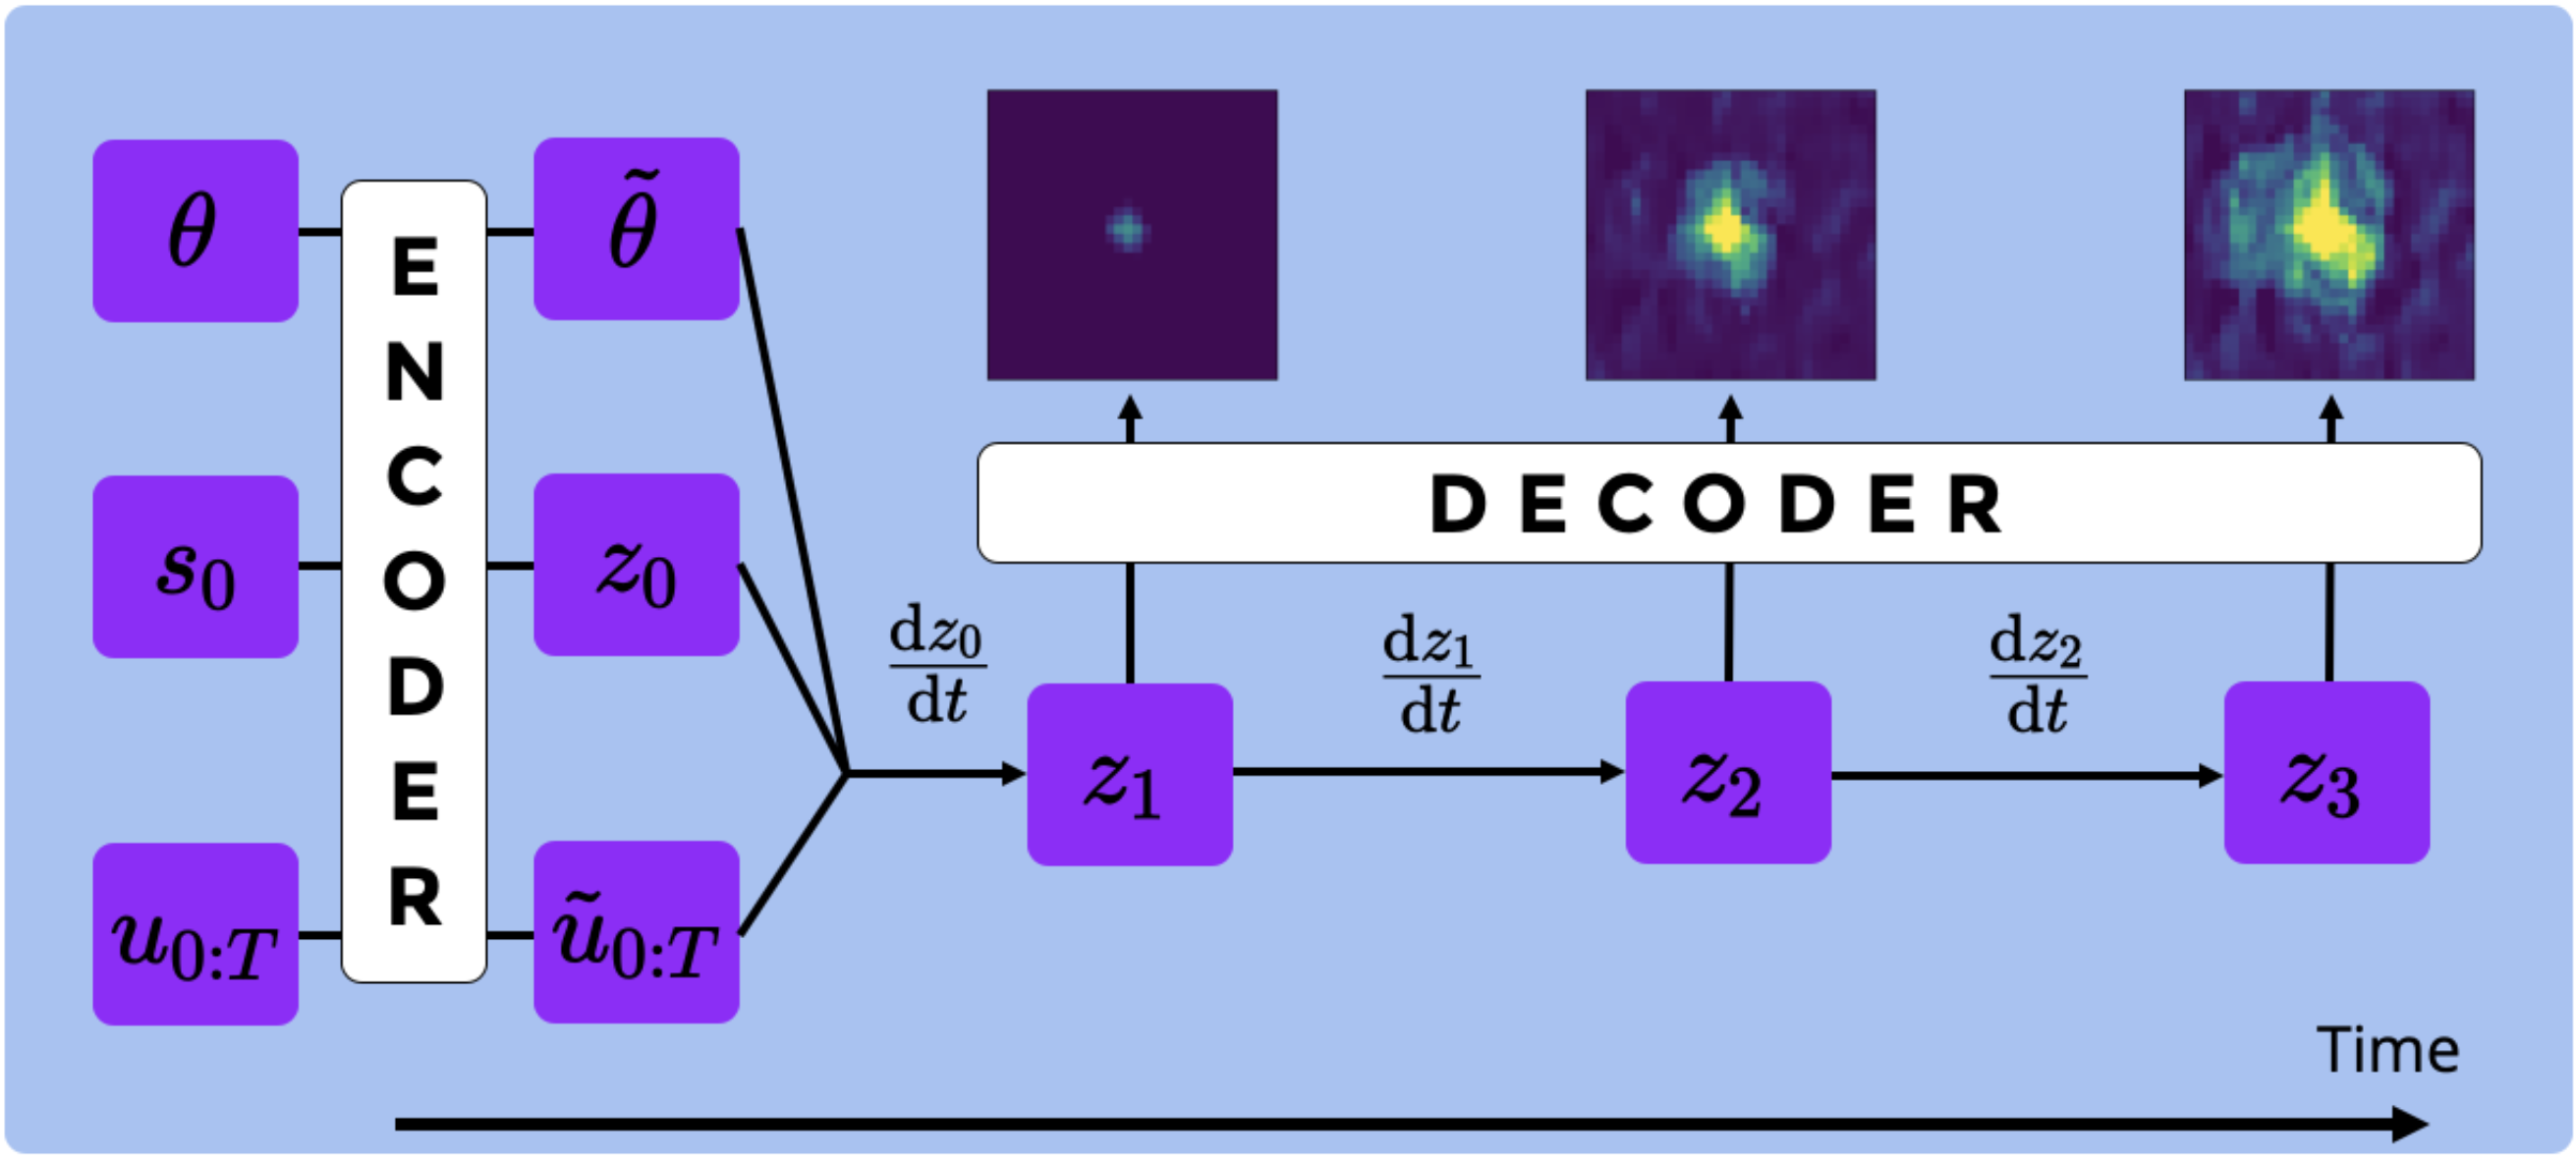</p>

In [1]:
import sys
sys.path.append('..')
import torch
from deepfield.datasets import FieldSample, FieldDataset
from deepfield.datasets.transforms import ToTensor, Normalize, AutoPadding, \
    AddBatchDimension, RemoveBatchDimension, Denormalize
from deepfield.metamodelling.training import NNTrainer
from deepfield.metamodelling.losses import L2Loss
from deepfield.metamodelling import init_metamodel
from utils import predict, make_loss_plot, make_comparison_plots, make_crossplots

## Load the data

At first, we should load our training data.

For training, we will use the `FieldSample` (`sample.hdf5`) created in [08.Dataset_and_Sample.ipynb](./08.Dataset_and_Sample.ipynb).

You can change the following variables:
- `DEVICE` specifies at which device the computations should go;
- `MAX_SEQUENCE_LEN` defines a length of a subsequence that fits into memory (NDE-b-ROM supports an intermediate dump into RAM);
- `TBPTT_STEP` is a length of step in a truncated backpropagation through time algorithm. The larger the step, the faster the computations, the more memory consumptive is training;
- `TBPTT_TAIL` is a number of time steps for which the gradients are propagated backwards in the truncated backpropagation through time algorithm. The larger the tail, the more exact are gradient, the more memory consumptive is training;
- `USE_CHECKPOINTING` set `True` if you want more memory-efficient training, set `False` if you want it to be faster;
- `N_EPOCH` number of times to pass through a dataset;

**Note:** `TBPTT_STEP` and `TBPTT_TAIL` each should not be greater than the length of a sample. If you do not want to use TBPTT, set `TBPTT_STEP = None` and `TBPTT_TAIL = None`.

In [2]:
PATH_TO_SAMPLE = './sample.hdf5'
DEVICE = torch.device('cuda:1')
MAX_SEQUENCE_LEN = 300
TBPTT_STEP = 150
TBPTT_TAIL = 150
USE_CHECKPOINTING = True
N_EPOCH = 500

Load the sample.
We also apply a whole bunch of `Transforms` to it, which make it acceptable for the NDE-b-ROM.

Previously unseen `AutoPadding` adds dummy computation cells at the borded of the field, making it suitable for a convolutional layers.

In [3]:
sample = FieldSample(PATH_TO_SAMPLE).load()
sample.transformed([ToTensor, Normalize, AutoPadding, AddBatchDimension], inplace=True)
dict(**sample.sample_attrs)

{'CONTROL': ['BHPT'],
 'GRID': ['XYZ'],
 'MASKS': ['ACTNUM',
  'TIME',
  'NAMED_WELL_MASK',
  'WELL_MASK',
  'CF_MASK',
  'PERF_MASK'],
 'ROCK': ['PORO', 'PERMX', 'PERMY', 'PERMZ'],
 'STATES': ['PRESSURE', 'SOIL', 'SWAT', 'SGAS', 'RS'],
 'TABLES': ['PVTO', 'PVTW', 'PVDG', 'SWOF', 'SGOF', 'DENSITY']}

We create the dataset directly from the single sample. And then load the statistics for `Normalize`.

In [4]:
dataset = FieldDataset(src=sample)
dataset.load_statistics('statistics.pkl')

## Create the Neural Networks

The modules of the NDE-b-ROM are constructed with the helper function `init_metamodel`.

For a more thorough understanding of the architecture, feel free to dig into the code: `../deepfield/metamodelling/rom.py`.

In [5]:
lsd, ae_kwargs, kwargs = init_metamodel(
    max_seq_len=MAX_SEQUENCE_LEN,
    device=DEVICE,
    use_checkpointing=USE_CHECKPOINTING
)

## Train the Neural Networks

Now, we are ready to train the model. There is a set of parameters that defines:
- training loss (you can specify the mask at which apply the loss): 
    - loss between predicted and ground truth `sample.states`;
    - loss between encoded-decoded and ground truth `sample.states`;
    - loss between encoded and predicted latent representation of the `sample.states`;
- `test_frac` - fraction of the samples reserved for validation (we have one sample, thus no validation);

In [6]:
nn_trainer = NNTrainer()
lsd, train_loss, test_loss = nn_trainer.train_model(
    lsd, 
    dataset, 
    n_epoch=N_EPOCH, 
    log_every=1, 
    test_frac=0, 
    dump_best_parameters='best_mm_parameters.pt',
    tbptt_step=TBPTT_STEP,
    tbptt_tail=TBPTT_TAIL,
    loss_pattern=(
        dict(mask='actnum', multiplier=1, loss_fn=L2Loss()), 
        dict(mask='well_mask', multiplier=1, loss_fn=L2Loss())
    ),
    latent_loss_pattern=(
        dict(mask=None, multiplier=2, loss_fn=L2Loss())
    ), 
    autoencoder_loss_pattern=(
        dict(mask='actnum', multiplier=1, loss_fn=L2Loss()), 
        dict(mask='well_mask', multiplier=1, loss_fn=L2Loss())
    ),
    **kwargs
)

epoch=1	iter=1 :
	Train Loss: 203.632721
epoch=2	iter=2 :
	Train Loss: 129.299133
...
epoch=500	iter=500 :
	Train Loss: 0.315304


We can plot the decrease of the loss with iterations:

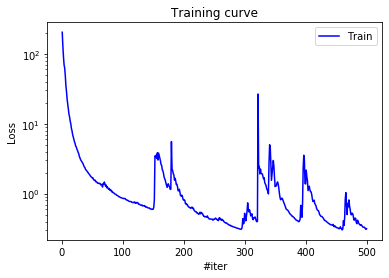

In [7]:
make_loss_plot(train_loss)

## Make predictions and analyze them

For predictions, first what we should do is to `RemoveBatchDimension` since the later visualisation is constructed for a single sample:

In [8]:
sample.transformed(RemoveBatchDimension, inplace=True)

Helper function `predict` returns two samples:
- sample with predicted states (all other attributes are the same as in original sample);
- sample with encoded-decoded states (all other attributes are the same as in original sample);

In [9]:
lsd.load('best_mm_parameters.pt')
sample_predicted, sample_autoencoder = predict(sample, lsd, kwargs, ae_kwargs, MAX_SEQUENCE_LEN, verbose=True)

Latent loss:	0.103039
Autoencoder loss: 	0.091144
Variational inference loss: 	0.194183
Mean loss (active cells): 0.284770
	PRESSURE loss: 	0.480452
	SOIL loss: 	0.173460
	SWAT loss: 	0.102466
	SGAS loss: 	0.181904
	RS loss: 	0.485568


In orded to look at true non-normalized values, let us `Denormalize` all the samples:

In [10]:
for s in (sample, sample_predicted, sample_autoencoder):
    s.transformed(Denormalize, inplace=True)

We can compare the predicted states and the true states in two different ways:
- Compare average values, 5th and 95th percentiles across the active cells (changing in time);
    - Solid line for the average;
    - Dotted line for the average across perforated cells;
    - Colored zone is between 5th and 95th percentiles;
- Plot the crossplots for all time stamps at once (allows a thorough analysis of the distributions of points);
    - Blue dots are all active cells;
    - Orange dots are perforated with wells;

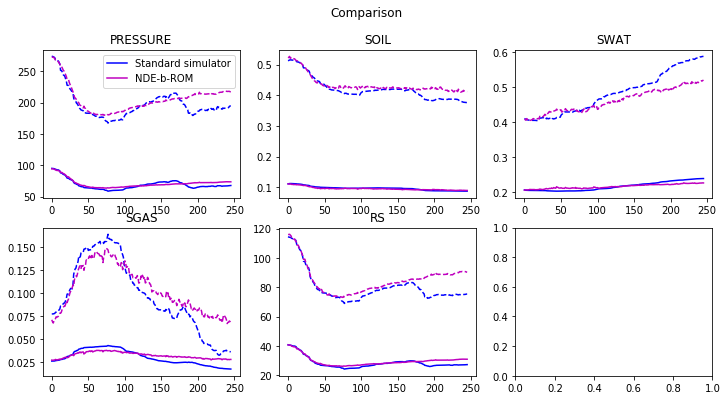

In [11]:
make_comparison_plots(
    sample.states, sample_predicted.states, 
    sample.sample_attrs.states, 'Standard simulator', 'NDE-b-ROM', sample.masks.well_mask
)

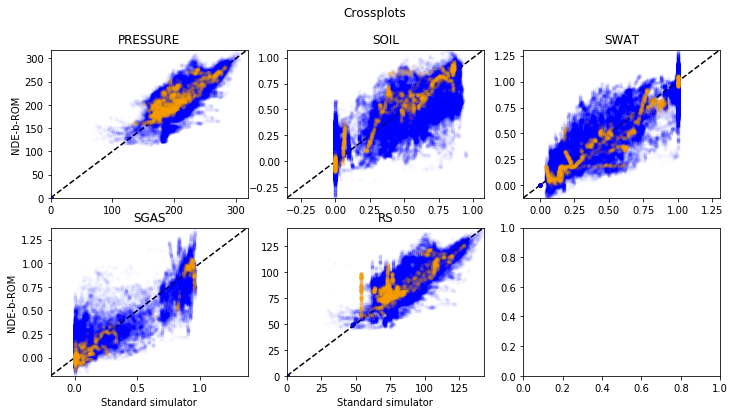

In [12]:
make_crossplots(
    sample.states, sample_predicted.states, 
    sample.sample_attrs.states, 'Standard simulator', 'NDE-b-ROM', sample.masks.well_mask
)

We also can provide the similar analysis for the states obtained by only encoding-decoding them (this is not applicable at inference time in the real world, but is useful for the analysis).

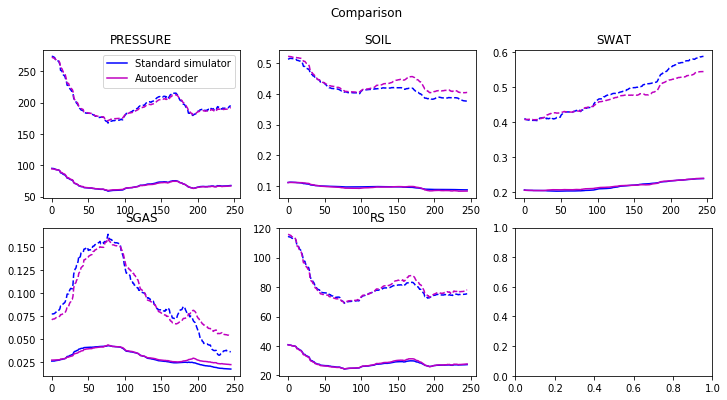

In [13]:
make_comparison_plots(
    sample.states, sample_autoencoder.states, 
    sample.sample_attrs.states, 'Standard simulator', 'Autoencoder', sample.masks.well_mask
)

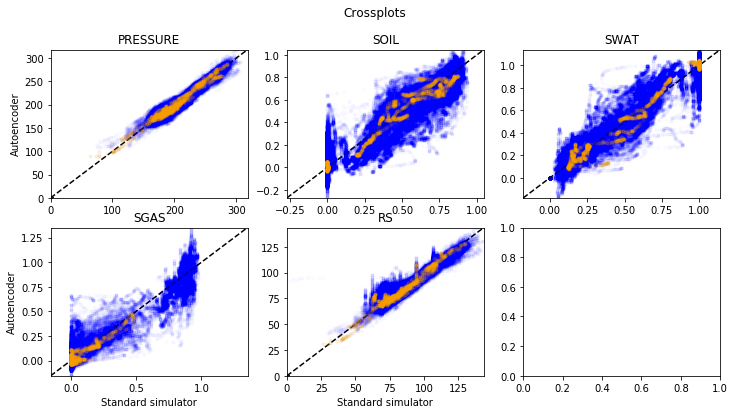

In [14]:
make_crossplots(
    sample.states, sample_autoencoder.states, 
    sample.sample_attrs.states, 'Standard simulator', 'Autoencoder', sample.masks.well_mask
)

To provide better results the model might also requre an adaptation (history matching) according to historical production rates. In the notebook [/pipelines/History_matching.ipynb](../pipelines/History_matching.ipynb) we demonstrate this procedure using the real-world reservoir model and production rates.